In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('cleaned_cardio.csv')
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,52,1,165,64.0,130,70,3,1,0,0,0,1
3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,48,1,156,56.0,100,60,1,1,0,0,0,0


In [3]:
x = df.drop(['cardio'], axis=1)
y = df['cardio']

In [4]:
num = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']

In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat)
    ]
)

In [6]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

models = [
    ('Random Forest', RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)),
    ('XGBoost', XGBClassifier(eval_metric='logloss', random_state=42))
]

In [7]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)


In [8]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
import numpy as np

best_model_name = ""
best_score = 0

for name, model in models:
    my_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    
    cv_scores = cross_val_score(my_pipeline, x, y, cv=kf, scoring='accuracy')
    
    avg_score = np.mean(cv_scores)
    
    print(f"--- {name} ---")
    print(f"Rotation's score: {cv_scores}")
    print(f"Average Accuracy: {avg_score * 100:.2f}%\n")
    
    if avg_score > best_score:
        best_score = avg_score
        best_model_name = name

print(f"The Winner is: {best_model_name} with {best_score * 100:.2f}% accuracy.")

--- Random Forest ---
Rotation's score: [0.7292863  0.73159818 0.74077112 0.73361175 0.72868969]
Average Accuracy: 73.28%

--- XGBoost ---
Rotation's score: [0.72689984 0.73055411 0.73629652 0.7324931  0.72809307]
Average Accuracy: 73.09%

The Winner is: Random Forest with 73.28% accuracy.


In [9]:
final_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)

final_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', final_model)])

final_pipeline.fit(x, y)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## Saving

Model saved


C:\Users\Dell\AppData\Local\Temp\ipykernel_3868\1735188378.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


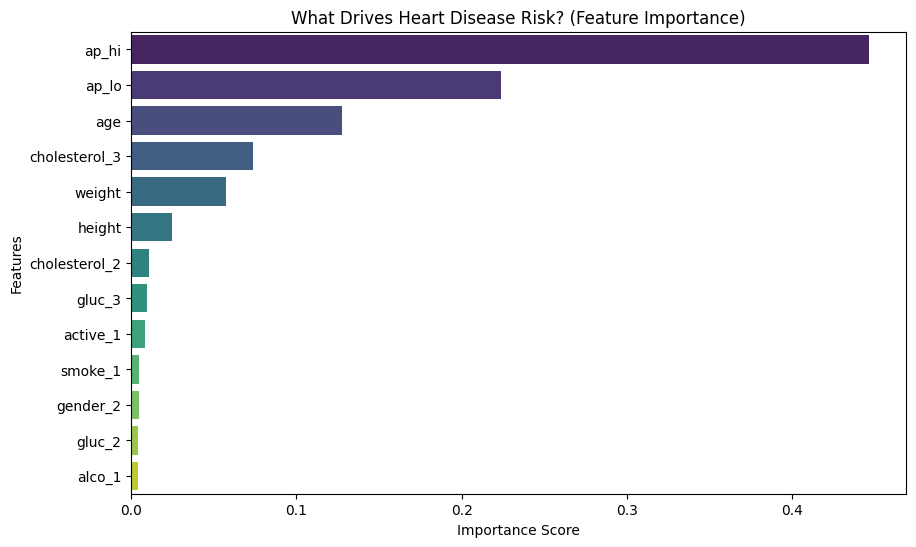

In [12]:
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

joblib.dump(final_pipeline, 'cardio_prediction_model.pkl')
print("Model saved")

preprocessor = final_pipeline.named_steps['preprocessor']
model = final_pipeline.named_steps['model']

cat_names = preprocessor.named_transformers_['cat'].get_feature_names_out(cat)
# Combine with numerical names
all_feature_names = num + list(cat_names)

# Get the importance scores
importances = model.feature_importances_

# Create a DataFrame for plotting
feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('What Drives Heart Disease Risk? (Feature Importance)')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()